# **I. Introduction**

> Nama: Cylia Wardana

> Batch: HCK - 004

### Problem Statement

Untuk mengetahui kelancaran pembayaran pengguna kartu kredit (dengan memisahkan nasabah yang rutin membayar dan tidak)

### Objective

Mengetahui mana user yang sering menunggak pembayaran kartu kredit atau yang tidak yang bisa mempengaruhi credit ratingnya

# **II. Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

#pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from feature_engine.outliers import Winsorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#multicollinearity test
from statsmodels.stats.outliers_influence import variance_inflation_factor

#model
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

#evaluasi
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix

#save
import joblib

import warnings
warnings.filterwarnings(action='ignore')

# **III. Data Loading**

#### BigQuery

SELECT limit_balance, CAST(sex as INT64) as sex, CAST(education_level AS INT64) as education_level, CAST(marital_status as INT64) as marital_status, age, pay_0, pay_2, pay_3, pay_4, CAST(pay_5 AS FLOAT64) as pay_5, CAST(pay_6 AS FLOAT64) as pay_6, bill_amt_1, bill_amt_2, bill_amt_3, bill_amt_4, bill_amt_5, bill_amt_6, pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, pay_amt_6, CAST(default_payment_next_month AS INT64) as default_payment_next_month

FROM `bigquery-public-data.ml_datasets.credit_card_default` 

LIMIT 7996

In [3]:
missing_values = ["n/a", "na", "--",'?',' nan', 'no',' ?']
data = pd.read_csv('h8dsft_P1M1_cylia_wardana.csv',na_values=missing_values)

Data loading dan mengecek non-standard missing value

In [4]:
df = data.copy()

In [576]:
pd.set_option('display.max.columns',None)

Menjabarkan semua nama kolom

In [440]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

Tipe data sudah sesuai dengan kolomnya

In [441]:
df.head(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,-1.0,54053.0,65235.0,64747.0,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,0.0,58180.0,59134.0,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,0.0,192461.0,195970.0,122214.0,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,0.0,133598.0,167378.0,171106.0,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,0.0,160879.0,161797.0,165107.0,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


Menampilkan 10 baris pertama

In [442]:
df.tail(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,1968.0,459.0,2500.0,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,-2.0,-2.0,12878.0,7702.0,2377.0,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,-2.0,-2.0,-100.0,100.0,0.0,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,-2.0,-1.0,5280.0,5000.0,5000.0,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,96.0,780.0,0.0,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,4280.0,2800.0,0.0,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,752.0,300.0,5880.0,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1473.0,390.0,390.0,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-70.0,9540.0,390.0,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


Menampilkan 10 baris terakhir

In [443]:
df.duplicated().sum()

1

Terdapat 1 baris duplikat

In [444]:
df.drop_duplicates(inplace=True)

In [445]:
df.duplicated().sum()

0

Baris yang duplikat dihilangkan

In [446]:
df.isnull().sum()

limit_balance                 0
sex                           0
education_level               0
marital_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64

Tidak terdapat missing value

In [447]:
df.rename(columns={"pay_6": "pay_apr", "pay_5": "pay_may",'pay_4':'pay_june','pay_3':'pay_july','pay_2':'pay_aug','pay_0':'pay_sept'},inplace=True)

In [448]:
df.head(1)

,limit_balance,sex,education_level,marital_status,age,pay_sept,pay_aug,pay_july,pay_june,pay_may,pay_apr,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1


Mengganti nama kolom pay, apabila pada kolom terdapat angka 1 berarti terjadi pada bulan September, angka 2 berarti bulan Agustus dan seterusnya sampai angka 6

# **IV. EDA / Exploratory Data Analysis**

[Text(0, 0, '2329'), Text(0, 0, '635')]

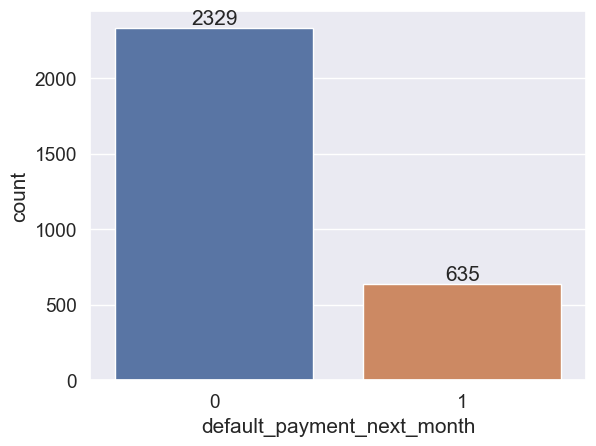

In [449]:
ax = sns.countplot(data=df, x='default_payment_next_month')
ax.bar_label(ax.containers[0])

Terlihat pada kolom default_payment_next_month untuk angka 0 lebih banyak daripada angka 1 dimana angka 0 artinya orang-orang yang tidak akan terkena default kartu kredit bulan depan sedangkan angka 1 menandakan bahwa orang tersebut akan terkena default / peringatan dari kreditor

<Axes: title={'center': 'Male vs Female'}, ylabel='sex'>

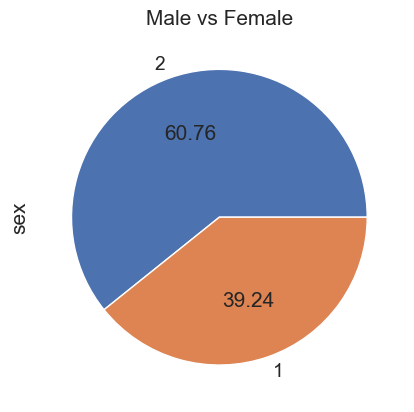

In [450]:
df.sex.value_counts().plot(kind='pie',autopct='%.2f', title= 'Male vs Female')

Keterangan sex; 1 = Laki-laki dan 2 = Perempuan

Bisa dilihat pada pie chart bahwa pengguna kartu kredit lebih banyak perempuan daripada laki-laki

[Text(0, 0, '262'), Text(0, 0, '373')]

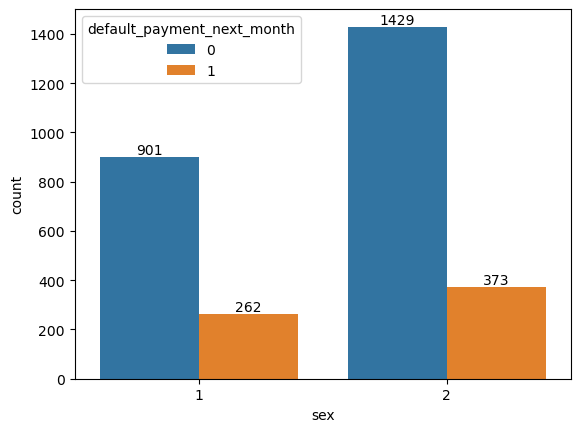

In [5]:
ax = sns.countplot(data=df, x='sex',hue='default_payment_next_month')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

Terlihat pada barplot diatas bahwa perempuan lebih banyak yang terkena default kartu kredit daripada laki-laki karena kembali lagi karena jumlah pengguna kartu kredit lebih banyak perempuan

In [451]:
df.groupby('education_level')[['default_payment_next_month']].count()

,default_payment_next_month
education_level,
0,2
1,1038
2,1400
3,483
4,13
5,24
6,4


Keterangan kolom education:
- 1 = graduate high school
- 2 = university
- 3 = high school
- 4 = others
- 0, 5 dan 6 = unknown

Bisa disimpulkan bahwa orang-orang yang lulus dari universitas paling banyak menggunakan kartu kredit (yang akan terkena default/peringatan ataupun tidak)

In [531]:
df.groupby(['education_level','default_payment_next_month'])[['default_payment_next_month']].count()

default_payment_next_month
education_level default_payment_next_month                            
0               0                                                    2
1               0                                                  861
                1                                                  177
2               0                                                 1058
                1                                                  342
3               0                                                  370
                1                                                  113
4               0                                                   13
5               0                                                   23
                1                                                    1
6               0                                                    2
                1                                                    2

Dapat terlihat bahwa orang-orang yang lulus dari universitas paling banyak yang akan terkena default (342) maupun yang tidak terkena default (1058), hal ini terkait dengan informasi diatas bahwa orang-orang lulusan universitas adalah yang paling banyak memakai kartu kredit

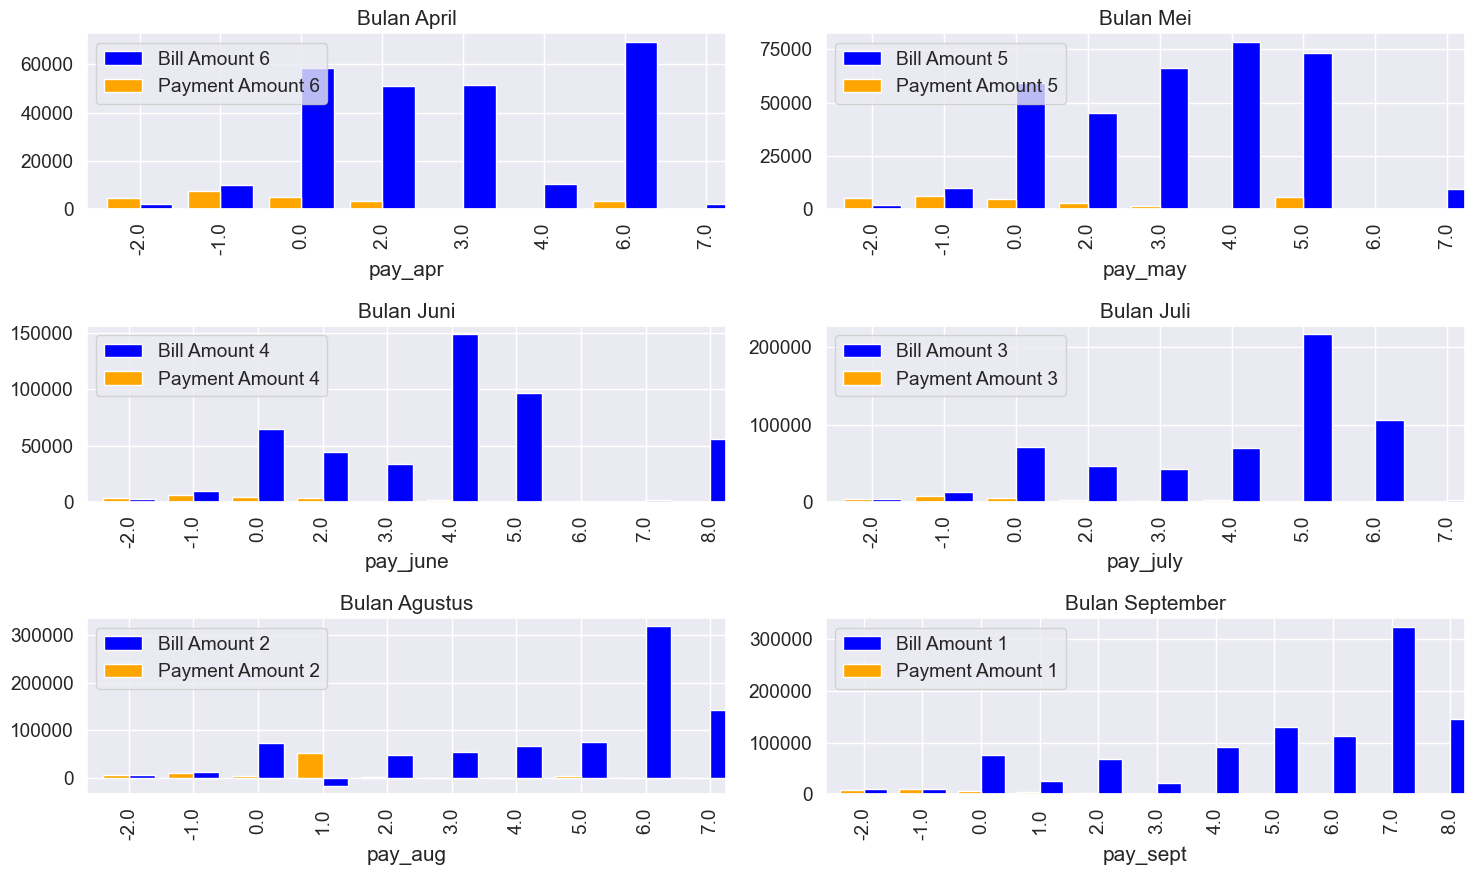

In [569]:
fig, axs = plt.subplots(3, 2, figsize=(15, 9))
df.groupby('pay_apr')['bill_amt_6'].mean().plot(kind='bar', ax=axs[0, 0], position=0, width=0.4, color='blue', label='Bill Amount 6')
df.groupby('pay_apr')['pay_amt_6'].mean().plot(kind='bar', ax=axs[0, 0], position=1, width=0.4, color='orange', label='Payment Amount 6')
axs[0, 0].legend()
axs[0, 0].set_title('Bulan April')
df.groupby('pay_may')['bill_amt_5'].mean().plot(kind='bar', ax=axs[0, 1], position=0, width=0.4, color='blue', label='Bill Amount 5')
df.groupby('pay_may')['pay_amt_5'].mean().plot(kind='bar', ax=axs[0, 1], position=1, width=0.4, color='orange', label='Payment Amount 5')
axs[0, 1].legend()
axs[0, 1].set_title('Bulan Mei')
df.groupby('pay_june')['bill_amt_4'].mean().plot(kind='bar', ax=axs[1, 0], position=0, width=0.4, color='blue', label='Bill Amount 4')
df.groupby('pay_june')['pay_amt_4'].mean().plot(kind='bar', ax=axs[1, 0], position=1, width=0.4, color='orange', label='Payment Amount 4')
axs[1, 0].legend()
axs[1, 0].set_title('Bulan Juni')
df.groupby('pay_july')['bill_amt_3'].mean().plot(kind='bar', ax=axs[1, 1], position=0, width=0.4, color='blue', label='Bill Amount 3')
df.groupby('pay_july')['pay_amt_3'].mean().plot(kind='bar', ax=axs[1, 1], position=1, width=0.4, color='orange', label='Payment Amount 3')
axs[1, 1].legend()
axs[1, 1].set_title('Bulan Juli')
df.groupby('pay_aug')['bill_amt_2'].mean().plot(kind='bar', ax=axs[2, 0], position=0, width=0.4, color='blue', label='Bill Amount 2')
df.groupby('pay_aug')['pay_amt_2'].mean().plot(kind='bar', ax=axs[2, 0], position=1, width=0.4, color='orange', label='Payment Amount 2')
axs[2, 0].legend()
axs[2, 0].set_title('Bulan Agustus')
df.groupby('pay_sept')['bill_amt_1'].mean().plot(kind='bar', ax=axs[2, 1], position=0, width=0.4, color='blue', label='Bill Amount 1')
df.groupby('pay_sept')['pay_amt_1'].mean().plot(kind='bar', ax=axs[2, 1], position=1, width=0.4, color='orange', label='Payment Amount 1')
axs[2, 1].legend()
axs[2, 1].set_title('Bulan September')
plt.tight_layout()
plt.show()

In [570]:
df.pay_sept.unique()

array([ 0.,  2.,  1., -1., -2.,  3.,  4.,  5.,  6.,  7.,  8.])

Data diatas merepresentasikan berapa lamanya orang menunggak pembayaran kartu kredit di bulan september (sama untuk bulan-bulan lainnya):
- Apabila angka 1 artinya dia menunggak pembayaran selama 1 bulan, dan seterusnya sampai 8 bulan
- Angka -2, -1, dan 0 artinya orang tersebut tidak menunggak pembayaran

Dimana hal ini didukung oleh grafik diatas bahwa orang-orang yang menunggak tidak pernah membayar sesuai dengan bill amount mereka atau malah tidak membayar sama sekali (payment amount = 0), ini bisa mempengaruhi apakah seseorang bisa terkena default atau tidak kedepannya

In [536]:
df.limit_balance.describe()

count      2964.000000
mean     163356.950067
std      125049.701016
min       10000.000000
25%       50000.000000
50%      140000.000000
75%      230000.000000
max      800000.000000
Name: limit_balance, dtype: float64

Limit balance kartu kredit pada data ini berkisar antara 10 000 - 800 000

In [546]:
df.groupby('default_payment_next_month')[['limit_balance']].mean()

,limit_balance
default_payment_next_month,
0,173924.431086
1,124598.425197


Rata-rata limit kartu kredit orang-orang yang masuk kategori 0 lebih tinggi daripada yang masuk kategori 1, berarti bisa diartikan bahwa orang-orang di dalam kategori 0 lebih lancar dalam melakukan pembayaran (tidak menunggak) sehingga limitnya tetap tinggi daripada kategori 1

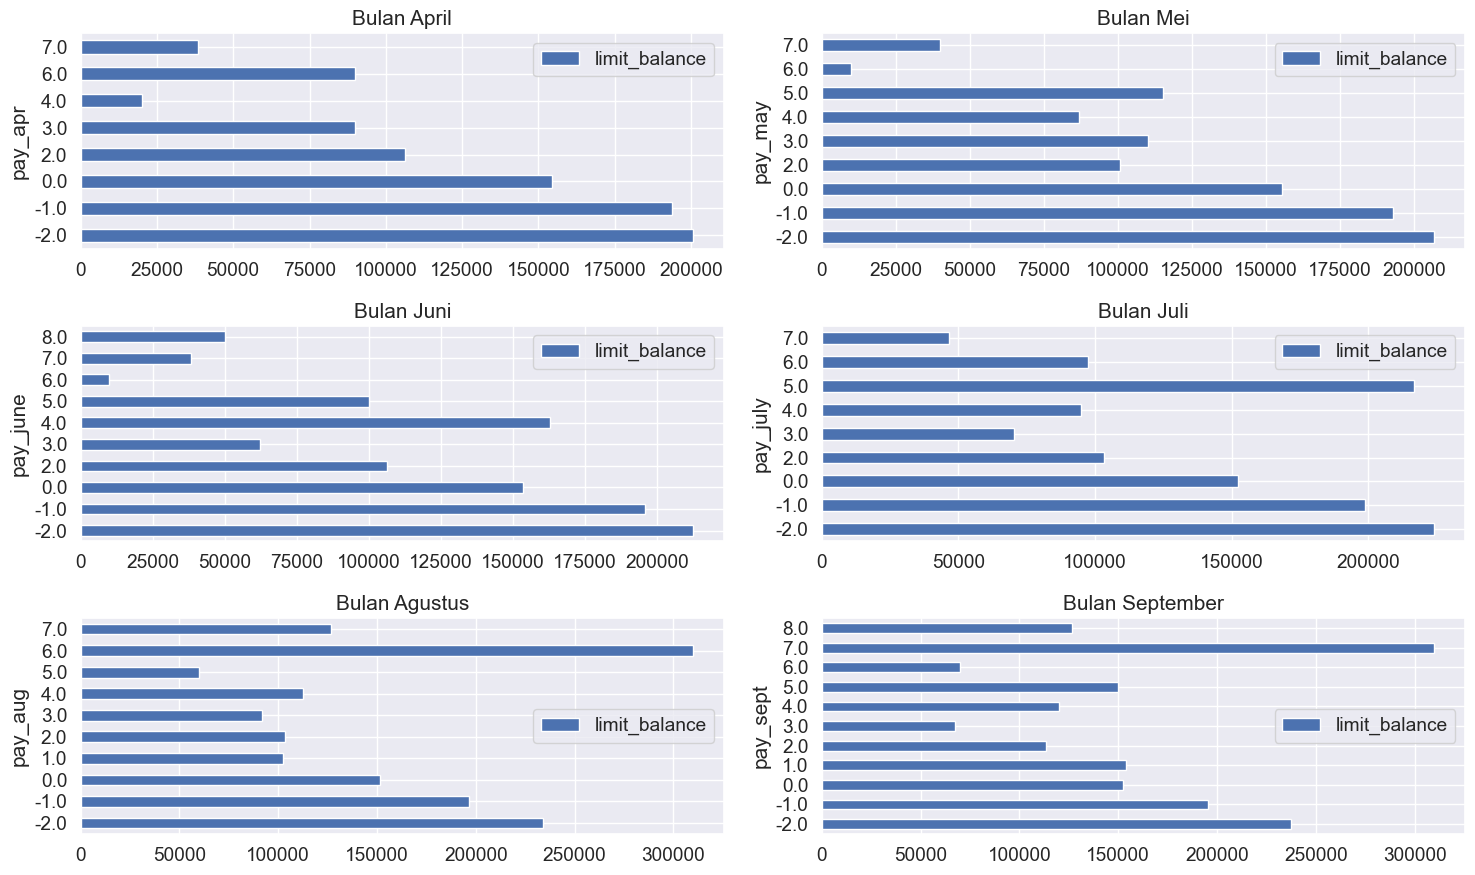

In [547]:
fig, axs = plt.subplots(3, 2, figsize=(15, 9))
df.groupby('pay_apr')[['limit_balance']].mean().plot(kind='barh',ax=axs[0, 0])
axs[0, 0].set_title('Bulan April')
df.groupby('pay_may')[['limit_balance']].mean().plot(kind='barh',ax=axs[0, 1])
axs[0, 1].set_title('Bulan Mei')
df.groupby('pay_june')[['limit_balance']].mean().plot(kind='barh',ax=axs[1, 0])
axs[1, 0].set_title('Bulan Juni')
df.groupby('pay_july')[['limit_balance']].mean().plot(kind='barh',ax=axs[1, 1])
axs[1, 1].set_title('Bulan Juli')
df.groupby('pay_aug')[['limit_balance']].mean().plot(kind='barh',ax=axs[2, 0])
axs[2, 0].set_title('Bulan Agustus')
df.groupby('pay_sept')[['limit_balance']].mean().plot(kind='barh',ax=axs[2, 1])
axs[2, 1].set_title('Bulan September')
plt.tight_layout()
plt.show()


In [551]:
df[df['pay_sept']==7]

,limit_balance,sex,education_level,marital_status,age,pay_sept,pay_aug,pay_july,pay_june,pay_may,pay_apr,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
1998,220000.0,2,1,1,41.0,7.0,6.0,5.0,4.0,3.0,2.0,243234.0,238172.0,232446.0,227800.0,225044.0,222356.0,0.0,0.0,0.0,0.0,0.0,6000.0,1
1999,400000.0,1,2,1,40.0,7.0,6.0,5.0,4.0,3.0,2.0,405366.0,397754.0,389903.0,384981.0,381863.0,359314.0,0.0,0.0,0.0,106.0,2281.0,42617.0,1


Walaupun demikian, saat diperiksa limit balance dari kartu kredit tiap bulan terlihat orang-orang yang rajin membayar/jarang menunggak tidak selalu memiliki rata-rata limit balance yang tinggi seperti yang terlihat di bulan Juli, Agustus dan September pada orang yang sama tetap memiliki limit balance yang tinggi, walaupun orang tersebut terkena default (hanya untuk beberapa kasus tertentu saja)

In [586]:
df['total_payment'] = df['pay_amt_1']+df['pay_amt_2']+df['pay_amt_3']+df['pay_amt_4']+df['pay_amt_5']+df['pay_amt_6']

In [588]:
df[df['default_payment_next_month']==0].total_payment.sum()

84976933.0

In [587]:
df[df['default_payment_next_month']==1].total_payment.sum()

11768819.0

Terlihat dari jumlah paymentnya, bahwa orang-orang yang dikategorikan 0 akan membayar tagihan mereka daripada orang-orang yang dikategorikan 1/yang akan dibekukan kartu kreditnya

In [579]:
df.age.describe()

count    2965.000000
mean       35.193255
std         9.109439
min        21.000000
25%        28.000000
50%        34.000000
75%        41.000000
max        69.000000
Name: age, dtype: float64

Orang-orang yang menggunakan kartu kredit dalam rentang usia 21 - 69 tahun

In [530]:
df.age.value_counts().head(5)

30.0    171
29.0    149
27.0    146
28.0    138
26.0    138
Name: age, dtype: int64

Orang yang paling banyak menggunakan kartu kredit adalah yang berumur 30 tahun

[Text(0.5, 1.0, 'Perilaku User Berdasarkan Usia')]

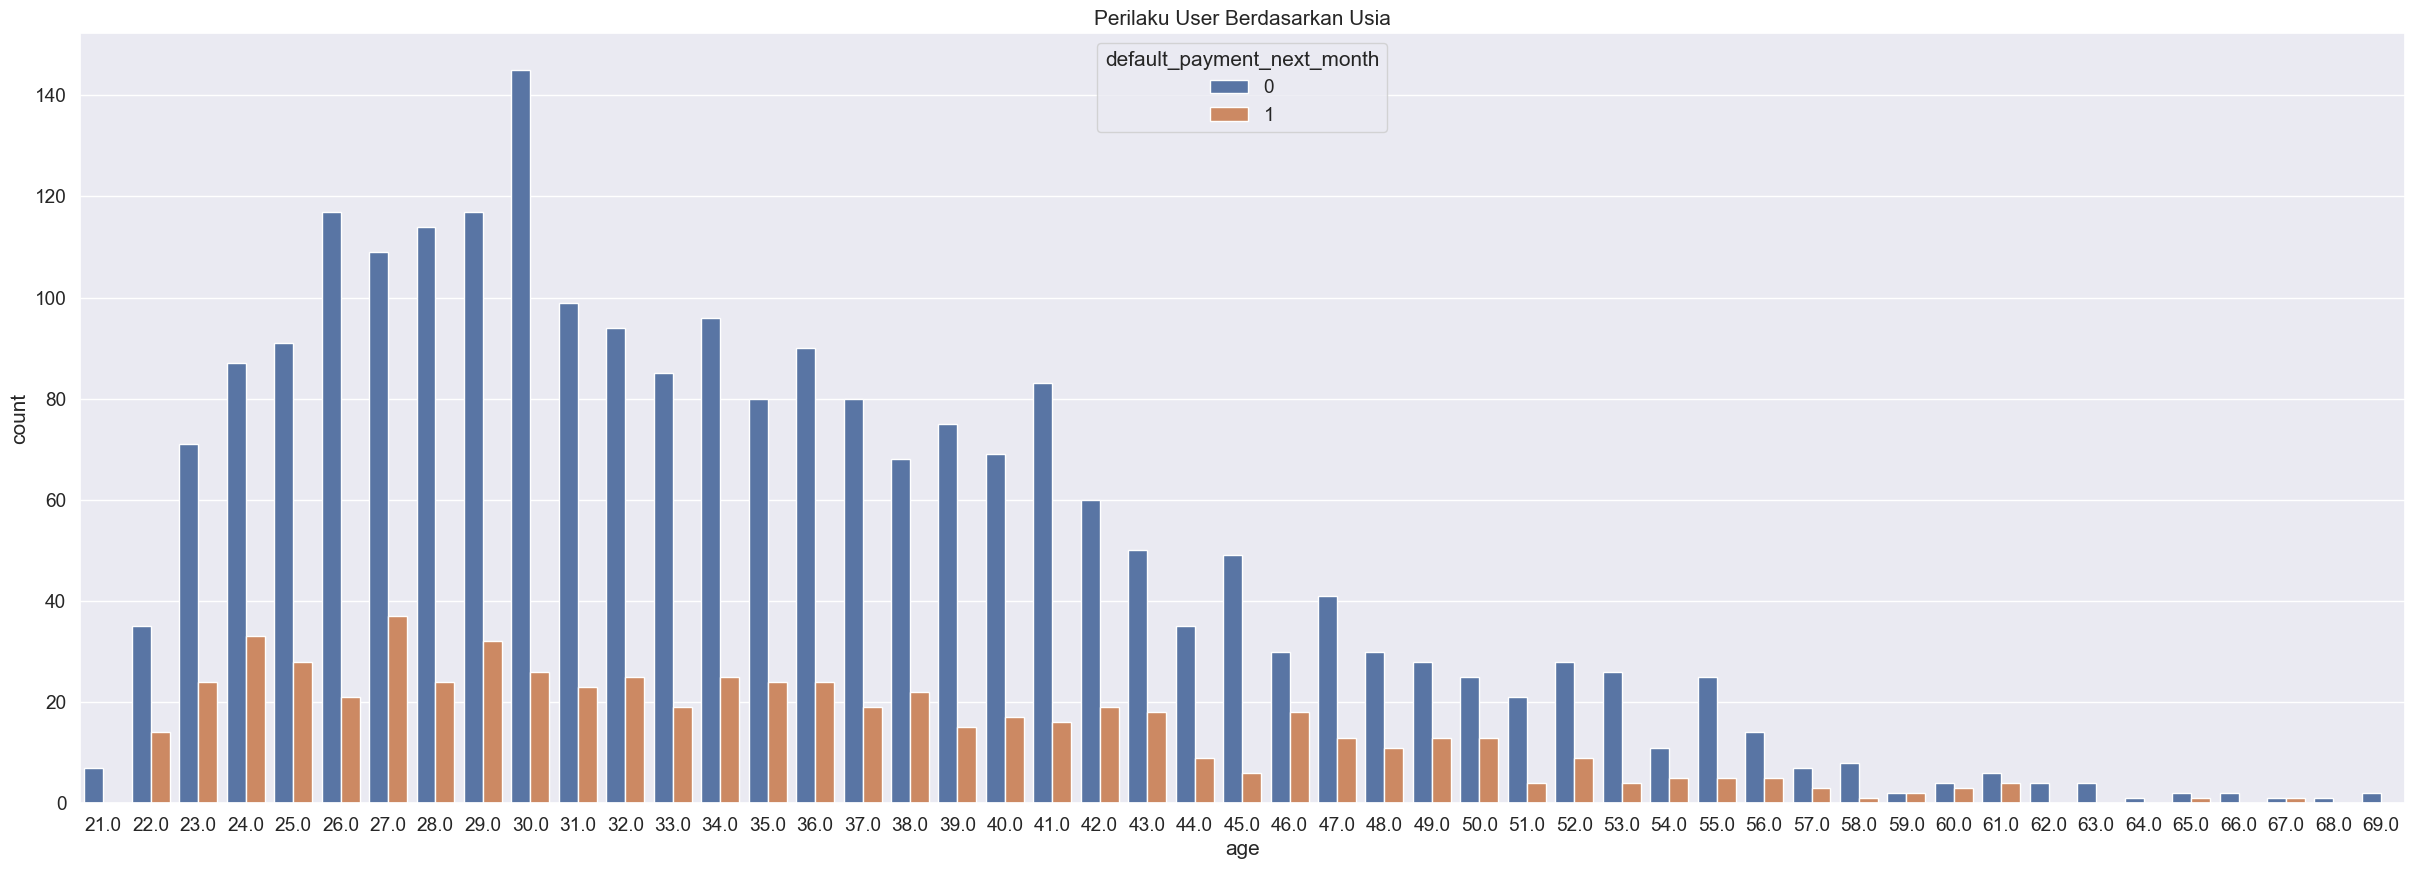

In [527]:
plt.figure(figsize=[30, 10])
sns.countplot( data = df,x = 'age', hue = 'default_payment_next_month').set(title='Perilaku User Berdasarkan Usia')

Terlihat juga pada grafik diatas bahwa orang-orang dibawah usia 45 tahun aktif menggunakan kartu kredit, dimana orang yang paling banyak dikategorikan 1 atau yang terkena default/mendapatkan peringatan adalah orang-orang yang berumur 27 tahun sedangkan yang paling lancar pembayarannya adalah yang berusia 30 tahun

### Cek Korelasi

In [455]:
#untuk melihat korelasi antara variabel kategorikal dan numerikal menggunakan phik matrix
df.phik_matrix().nlargest(15,'default_payment_next_month')['default_payment_next_month']

interval columns not set, guessing: ['limit_balance', 'sex', 'education_level', 'marital_status', 'age', 'pay_sept', 'pay_aug', 'pay_july', 'pay_june', 'pay_may', 'pay_apr', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 'default_payment_next_month']


default_payment_next_month    1.000000
pay_sept                      0.596572
pay_aug                       0.468335
pay_apr                       0.386559
pay_july                      0.334726
pay_june                      0.318688
pay_may                       0.315415
limit_balance                 0.191907
bill_amt_4                    0.087360
education_level               0.085359
pay_amt_3                     0.083774
bill_amt_1                    0.073974
bill_amt_3                    0.073073
age                           0.067038
bill_amt_2                    0.064086
Name: default_payment_next_month, dtype: float64

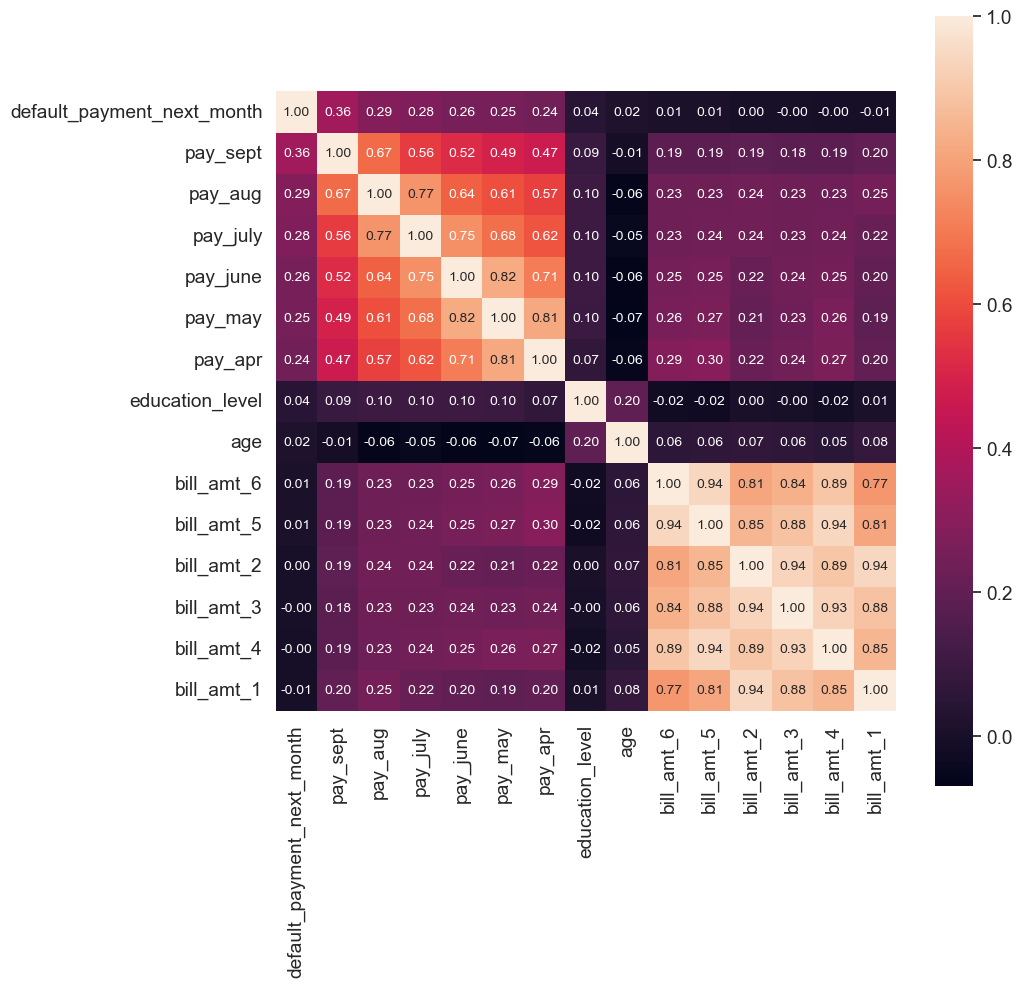

In [456]:
#uji korelasi
k=15
plt.figure(figsize=(10,10))
cols = df.corr(numeric_only = True).nlargest(k, 'default_payment_next_month')['default_payment_next_month'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [457]:
df.corr(numeric_only = True).nlargest(k, 'default_payment_next_month')['default_payment_next_month']

default_payment_next_month    1.000000
pay_sept                      0.357185
pay_aug                       0.288669
pay_july                      0.275608
pay_june                      0.255648
pay_may                       0.253161
pay_apr                       0.237007
education_level               0.044745
age                           0.016883
bill_amt_6                    0.005994
bill_amt_5                    0.005807
bill_amt_2                    0.000751
bill_amt_3                   -0.001200
bill_amt_4                   -0.004844
bill_amt_1                   -0.006089
Name: default_payment_next_month, dtype: float64

Melihat 15 kolom yang paling berkorelasi (positif) terhadap kolom default payment

In [458]:
df.corr(numeric_only = True).nsmallest(k, 'default_payment_next_month')['default_payment_next_month']

limit_balance    -0.161868
pay_amt_3        -0.090318
pay_amt_6        -0.067025
pay_amt_1        -0.066221
pay_amt_5        -0.066214
pay_amt_2        -0.059307
pay_amt_4        -0.053748
marital_status   -0.026193
sex              -0.021626
bill_amt_1       -0.006089
bill_amt_4       -0.004844
bill_amt_3       -0.001200
bill_amt_2        0.000751
bill_amt_5        0.005807
bill_amt_6        0.005994
Name: default_payment_next_month, dtype: float64

Sebaliknya, melihat 15 kolom yang paling berkorelasi (secara negatif) terhadap kolom default payment

Dari hasil uji korelasi dan phik matrix, didapatkan fitur-fitur yang berkolerasi dengan kolom default_payment antara lain: pay_apr sampai pay_sept, education_level, age yang berkorelasi secara positif dan limit_balance yang berkorelasi secara negatif

# **V. Feature Engineering**

### Split

In [459]:
df2 = df.iloc[:,[0,2,4,5,6,7,8,9,10,-1]]
df2.head(10)

,limit_balance,education_level,age,pay_sept,pay_aug,pay_july,pay_june,pay_may,pay_apr,default_payment_next_month
0,80000.0,6,54.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,200000.0,4,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,20000.0,6,22.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,260000.0,4,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,150000.0,4,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,0
5,300000.0,4,32.0,0.0,0.0,0.0,0.0,0.0,-1.0,0
6,130000.0,1,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,200000.0,1,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,500000.0,1,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,230000.0,1,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Fitur-Fitur yang terpilih dari hasil uji korelasi

In [460]:
df2['education_level']=df2['education_level'].replace([0,5,6],4)

In [491]:
df2.education_level.unique()

array([4, 1, 2, 3])

Mengganti angka 0, 5 dan 6 dengan angka 4 yang berarti 'others' (karena 0, 5 dan 6 tidak ada keterangannya) pada kolom education level

In [461]:
#split
X = df2.drop('default_payment_next_month',axis=1) #fitur
y = df2['default_payment_next_month'] #target
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify=y) #parameter stratify = y, agar proporsi antar kategori sama

In [462]:
train_concat = pd.concat([X_train,y_train],axis=1)

In [463]:
X_train2 = X_train.copy()

In [464]:
#multicollinearity test
def calc_vif(A):
    vif = pd.DataFrame()
    vif["variables"] = A.columns
    vif["VIF"] = [variance_inflation_factor(A.values, i) for i in range(A.shape[1])]
    return(vif)

Membuat function untuk cek multicollinearity test antar variabel dengan menghitung nilai VIF

In [465]:
calc_vif(X_train2)

,variables,VIF
0,limit_balance,2.904216
1,education_level,6.545544
2,age,9.110249
3,pay_sept,1.908891
4,pay_aug,3.205538
5,pay_july,3.364611
6,pay_june,4.014668
7,pay_may,4.767542
8,pay_apr,3.210983


Untuk fitur yang dipilih tidak ada yang melebihi angka 10, berarti sudah tidak ada / hanya sedikit multicollinearity antar variabel

In [466]:
num_col = ['limit_balance','age']
kat_col = ['education_level','pay_sept','pay_aug','pay_july','pay_june','pay_may','pay_apr']

Memisahkan kolom kategori dan kolom numerik pada fitur

### Cara Manual

#### Handle Outliers

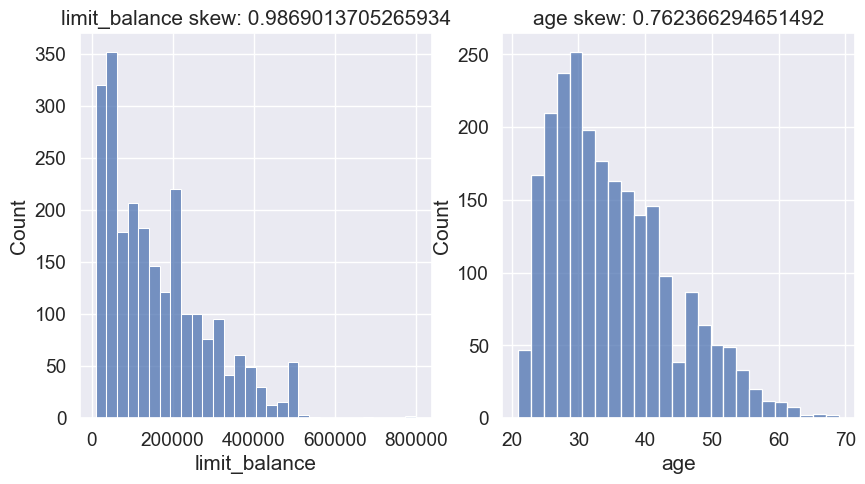

In [467]:
fig, ax = plt.subplots(ncols=2, figsize=[10,5])
ax = ax.flatten()

for idx, col in enumerate(num_col):
    sns.histplot(train_concat[col], ax=ax[idx])
    ax[idx].set_title(f'{num_col[idx]} skew: {train_concat[col].skew()}')

Melihat skewness pada kolom numerik dimana kolom limit balance dan age tidak terdistribusi normal (skewness limit_balance = 0.98 dan skewness age = 0.76)

In [468]:
Q1 = train_concat['limit_balance'].quantile(.25)
Q3 = train_concat['limit_balance'].quantile(.75)

IQR = Q3 - Q1

upper = Q3 + (1.5*IQR)
lower = Q1 - (1.5*IQR)

outlier = train_concat[(train_concat['limit_balance'] <= lower) | (train_concat['limit_balance'] >= upper)]

print('percentage: ', len(outlier)/df.shape[0] * 100, '%')
print('upper: ', upper)
print('lower: ', lower)

percentage:  1.9230769230769231 %
upper:  500000.0
lower:  -220000.0


In [469]:
Q1 = train_concat['age'].quantile(.25)
Q3 = train_concat['age'].quantile(.75)

IQR = Q3 - Q1

upper = Q3 + (1.5*IQR)
lower = Q1 - (1.5*IQR)

outlier = train_concat[(train_concat['age'] <= lower) | (train_concat['age'] >= upper)]

print('percentage: ', len(outlier)/df.shape[0] * 100, '%')
print('upper: ', upper)
print('lower: ', lower)

percentage:  0.708502024291498 %
upper:  60.5
lower:  8.5


Karena keduanya tidak terdistribusi normal, maka menggunakan cara IQR untuk menghitung outliers beserta persentasenya

In [470]:
wins = Winsorizer(capping_method='iqr', tail='both', fold=1.5,
                  variables=['limit_balance','age'], missing_values='ignore')

X_train2 = wins.fit_transform(X_train2)
X_train2.describe()

,limit_balance,education_level,age,pay_sept,pay_aug,pay_july,pay_june,pay_may,pay_apr
count,2371.000000,2371.000000,2371.000000,2371.000000,2371.000000,2371.00000,2371.000000,2371.000000,2371.000000
mean,162075.073809,1.838887,35.056727,-0.019401,-0.129059,-0.13876,-0.176719,-0.218895,-0.251371
std,123042.976672,0.748121,8.927429,1.094117,1.168234,1.17415,1.181602,1.158603,1.163108
min,10000.000000,1.000000,21.000000,-2.000000,-2.000000,-2.00000,-2.000000,-2.000000,-2.000000
25%,50000.000000,1.000000,28.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000
50%,140000.000000,2.000000,33.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,230000.000000,2.000000,41.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,500000.000000,4.000000,60.500000,8.000000,7.000000,7.00000,8.000000,7.000000,7.000000


Melakukan teknik censoring/capping untuk handle outliers menggunakan Winsorizer

#### Scaling

In [471]:
scaler = MinMaxScaler()
X_train2[num_col] = scaler.fit_transform(X_train2[num_col])

Melakukan scaling pada kolom numerik menggunakan minmaxscaler karena data tidak normal

#### Encode

In [472]:
# education_cat = [3,2,1,4]
# pay_sept = [-2,-1,0,1,2,3,4,5,6,7,8]
# pay_aug = [-2,-1,0,1,2,3,4,5,6,7]
# pay_july = [-2,-1,0,2,3,4,5,6,7]
# pay_june = [-2,-1,0,2,3,4,5,6,7,8]
# pay_may = [-2,-1,0,2,3,4,5,6,7]
# pay_apr = [-2,-1,0,2,3,4,6,7]

ord_enc = OrdinalEncoder()
cat_ord = pd.DataFrame(ord_enc.fit_transform(X_train2[['education_level','pay_sept','pay_aug','pay_july','pay_june','pay_may','pay_apr']]))

Melakukan encoding pada kolom kategorik dengan menggunakan ordinalencoder

### Cara Pipeline

In [473]:
num_pipeline = Pipeline([
        ('outlier', Winsorizer(capping_method='iqr', tail='both', fold=1.5)),
        ('scaler', MinMaxScaler())
    ])

num_tr = num_pipeline.fit_transform(X_train[['limit_balance','age']])

Membuat pipeline untuk handle kolom numerik

In [474]:
cat_pipeline = Pipeline([('ordinal_enc', OrdinalEncoder())])

cat_tr = cat_pipeline.fit_transform(X_train[['education_level','pay_sept','pay_aug','pay_july','pay_june','pay_may','pay_apr']])

Membuat pipeline untuk handle kolom kategorik ordinal

In [475]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, ['limit_balance','age']),
        ("cat_ord", cat_pipeline, ['education_level','pay_sept','pay_aug','pay_july','pay_june','pay_may','pay_apr'])
    ])

train_tr = full_pipeline.fit_transform(X_train)

Menggabungkan pipeline numerik dan kategorik dan dilakukan fit_transform pada data train

In [476]:
test_tr = full_pipeline.transform(X_test)

Dilakukan transform pada data test

# **VI. Model Definition and Model Evaluation**

In [477]:
log_model = LogisticRegression(max_iter=100000) # Defining Logistic Regression Model
svm_model = SVC()                               # Defining SVM Classifier Model   
dt_model = DecisionTreeClassifier()             # Defining Decision Tree Classifier Model
rf_model = RandomForestClassifier()             # Defining Random Forest Classifier Model
knn_model = KNeighborsClassifier()              # Defining KNN Classifier Model
nb_model = GaussianNB()                         # Defining Naive Bayes Model
adaboost_model = AdaBoostClassifier()           # Defining AdaBoost Classifier Model

Model-model yang akan digunakan

### Cross-Validation

In [478]:
skfold=StratifiedKFold(n_splits=5)

Menggunakan teknik stratified KFold untuk Cross Validation

In [479]:
cv_log_model = cross_val_score(log_model, train_tr, y_train, cv=skfold, scoring="recall")
cv_svm_model = cross_val_score(svm_model, train_tr, y_train, cv=skfold, scoring="recall")
cv_dt_model = cross_val_score(dt_model, train_tr, y_train, cv=skfold, scoring="recall")
cv_rf_model = cross_val_score(rf_model, train_tr, y_train, cv=skfold, scoring="recall")
cv_knn_model = cross_val_score(knn_model, train_tr, y_train, cv=skfold, scoring="recall")
cv_nb_model = cross_val_score(nb_model, train_tr, y_train, cv=skfold, scoring="recall")
cv_ada_model = cross_val_score(adaboost_model, train_tr, y_train, cv=skfold, scoring="recall")
name_model = []
cv_scores=0
for cv,name in zip([cv_log_model,cv_svm_model,cv_dt_model,cv_rf_model,cv_knn_model,cv_nb_model,cv_ada_model],['log_model','svm_model','dt_model','rf_model','knn_model','nb_model','adaboost_model']):
    print(name)
    print('recall - All - Cross Validation  : ', cv)
    print('recall - Mean - Cross Validation : ', cv.mean())
    print('recall - Std - Cross Validation  : ', cv.std())
    print('recall - Range of Test-Set       : ', (cv.mean()-cv.std()) , '-', (cv.mean()+cv.std()))
    print('-'*50)
    if cv.mean()>cv_scores:
        cv_scores = cv.mean()
        name_model = name
    else:
        pass
print('best model:', name_model)
print('cross-val mean:', cv_scores)

log_model
recall - All - Cross Validation  :  [0.30392157 0.30693069 0.33663366 0.28431373 0.32352941]
recall - Mean - Cross Validation :  0.31106581246359927
recall - Std - Cross Validation  :  0.0178486408286518
recall - Range of Test-Set       :  0.2932171716349475 - 0.32891445329225105
--------------------------------------------------
svm_model
recall - All - Cross Validation  :  [0.33333333 0.37623762 0.34653465 0.31372549 0.46078431]
recall - Mean - Cross Validation :  0.3661230828965249
recall - Std - Cross Validation  :  0.05151200738426058
recall - Range of Test-Set       :  0.3146110755122643 - 0.4176350902807855
--------------------------------------------------
dt_model
recall - All - Cross Validation  :  [0.43137255 0.44554455 0.48514851 0.39215686 0.47058824]
recall - Mean - Cross Validation :  0.4449621432731508
recall - Std - Cross Validation  :  0.032388439231634966
recall - Range of Test-Set       :  0.41257370404151583 - 0.4773505825047858
--------------------------

Cross Validation seluruh model menggunakan scoring recall karena lebih fokus pada false negative (pada kasus ini), yang artinya melihat orang yang sebenarnya masuk ke dalam kategori 1 (yang suka menunggak) namun salah diprediksi menjadi kategori 0 sehingga akan merugikan bank. Didapatkan pada hasil cross validation bahwa model naives-bayes adalah yang terbaik (0.47) namun karena ingin dilakukan hyperparameter tuning dan model ini hanya memiliki sedikit parameter, maka diputuskan untuk mengambil model kedua terbaik saja yaitu model decision tree dengan validation score 0.44

In [480]:
def base_model_train_eval(model):
    mod = model
    mod.fit(train_tr, y_train)

    mod_train = mod.predict(train_tr)
    mod_test = mod.predict(test_tr)

    cm = confusion_matrix(y_test, mod_test, labels=mod.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=mod.classes_)

    print(classification_report(y_train, mod_train,target_names=['Default No', 'Default Yes']))
    print(classification_report(y_test, mod_test,target_names=['Default No', 'Default Yes']))
    disp.plot()
    plt.show()

Membuat function untuk mempermudah evaluasi model yang akan digunakan (confusion matrix, confusionmatrixdisplay dan classification report)

              precision    recall  f1-score   support

  Default No       0.87      0.92      0.89      1863
 Default Yes       0.63      0.48      0.54       508

    accuracy                           0.83      2371
   macro avg       0.75      0.70      0.72      2371
weighted avg       0.82      0.83      0.82      2371

              precision    recall  f1-score   support

  Default No       0.87      0.90      0.88       466
 Default Yes       0.56      0.49      0.52       127

    accuracy                           0.81       593
   macro avg       0.71      0.69      0.70       593
weighted avg       0.80      0.81      0.80       593



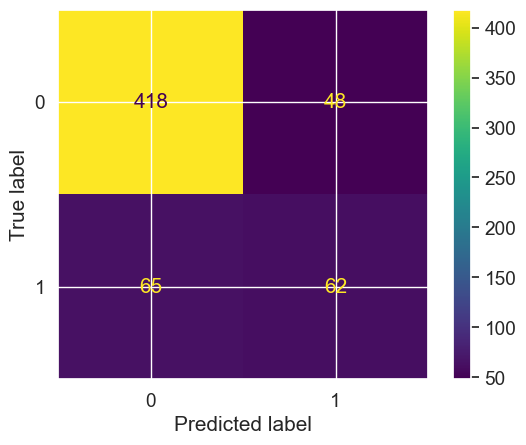

In [481]:
base_model_train_eval(GaussianNB())

Melakukan evaluasi pada model terbaik yaitu Naives-Bayes dimana ditemukan bahwa nilai recall untuk kategori 0 (tidak terkena default) sudah cukup baik yaitu 0.90 sedangkan untuk kategori 1 (terkena default, sering menunggak) adalah 0.49 ini bisa terjadi karena data imbalance. Model lebih bisa memprediksi orang-orang yang masuk kedalam kategori 0. Pada classification report, terlihat pada data train dan data test recall tidak berbeda jauh. Pada confusion matrix diatas ditemukan bahwa model sudah bisa mengkategorikan dengan benar sebanyak 480 orang (True Positive + True Negative). Namun pada matrix juga terlihat bahwa orang-orang yang seharusnya dikategorikan 1 namun diprediksi masuk ke dalam kategori 0 masih ada 65 orang (False Negative) dimana seharusnya pada kasus ini sebisa mungkin meminimalisir angka dari false negativenya

              precision    recall  f1-score   support

  Default No       0.98      1.00      0.99      1863
 Default Yes       1.00      0.93      0.96       508

    accuracy                           0.98      2371
   macro avg       0.99      0.97      0.98      2371
weighted avg       0.99      0.98      0.98      2371

              precision    recall  f1-score   support

  Default No       0.84      0.81      0.82       466
 Default Yes       0.38      0.43      0.41       127

    accuracy                           0.73       593
   macro avg       0.61      0.62      0.61       593
weighted avg       0.74      0.73      0.73       593



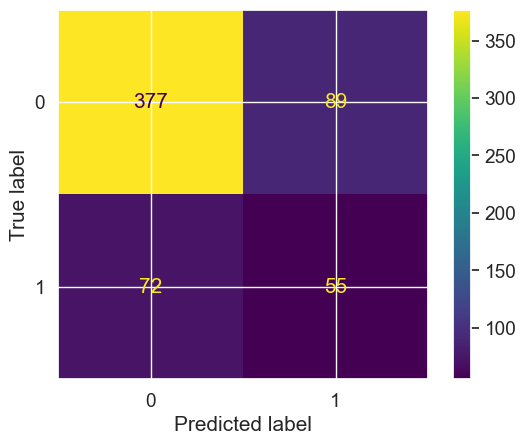

In [482]:
base_model_train_eval(DecisionTreeClassifier())

Setelah dilakukan hyperparameter tuning pada model Decision Tree: Melakukan evaluasi pada model kedua terbaik yaitu Decision Tree dimana ditemukan bahwa nilai recall untuk kategori 0 (tidak terkena default) yaitu 0.81 sedangkan untuk kategori 1 (terkena default, sering menunggak) adalah 0.43 ini bisa terjadi karena data imbalance. Model lebih bisa memprediksi orang-orang yang masuk kedalam kategori 0. Pada classification report, terlihat data train dan data test recall lebih baik daripada sebelum dilakukan tuning walaupun masih sedikit overfit. Pada classification report, terlihat pada data train dan data test recall terjadi overfitting, ini mungkin bisa terjadi karena sample yang digunakan train sedikit. Pada confusion matrix diatas ditemukan bahwa model sudah bisa mengkategorikan dengan benar sebanyak 432 orang (True Positive + True Negative), lebih sedikit daripada model Naives-Bayes. Pada matrix juga terlihat bahwa orang-orang yang seharusnya dikategorikan 1 namun diprediksi masuk ke dalam kategori 0 masih ada 72 orang (False Negative) dimana seharusnya pada kasus ini sebisa mungkin meminimalisir angka dari false negativenya

### Hyperparameter Tuning

In [483]:
#hyperparameter tuning pada model decision tree
params = [       
     {'max_features': np.arange(0,10),  
     'min_samples_split': np.arange(0,10),          
     'max_depth': np.arange(0,10),              
     'criterion': ['gini', 'entropy','log_loss']}
  ]

dtc = DecisionTreeClassifier(random_state=1)

grid_search = GridSearchCV(dtc, params, cv=10,
                           scoring='recall',
                           return_train_score=True)
grid_search.fit(train_tr, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1),
             param_grid=[{'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_depth': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                          'max_features': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                          'min_samples_split': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}],
             return_train_score=True, scoring='recall')

In [484]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 2,
 'min_samples_split': 8}

Didapatkan best parameter dari model decision tree

In [485]:
grid_search.best_score_

0.4251764705882353

In [486]:
model_tuned = grid_search.best_estimator_

model_tuned.fit(train_tr, y_train)

model_tuned_train = model_tuned.predict(train_tr)
model_tuned_test = model_tuned.predict(test_tr)

print(classification_report(y_train, model_tuned_train,target_names=['Default No', 'Default Yes']))
print(classification_report(y_test, model_tuned_test,target_names=['Default No', 'Default Yes']))

              precision    recall  f1-score   support

  Default No       0.86      0.97      0.91      1863
 Default Yes       0.78      0.41      0.54       508

    accuracy                           0.85      2371
   macro avg       0.82      0.69      0.73      2371
weighted avg       0.84      0.85      0.83      2371

              precision    recall  f1-score   support

  Default No       0.85      0.93      0.89       466
 Default Yes       0.61      0.38      0.47       127

    accuracy                           0.81       593
   macro avg       0.73      0.66      0.68       593
weighted avg       0.80      0.81      0.80       593



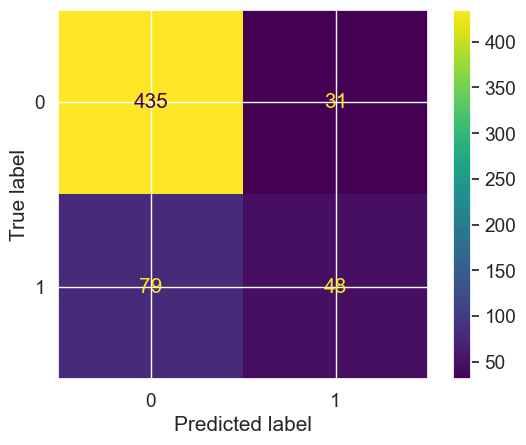

In [487]:
cm = confusion_matrix(y_test, model_tuned_test, labels=model_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_tuned.classes_)
disp.plot()
plt.show()

Melakukan evaluasi kembali pada model Decision Tree dimana ditemukan bahwa nilai recall untuk kategori 0 (tidak terkena default) menjadi 0.93 sedangkan untuk kategori 1 (terkena default, sering menunggak) adalah 0.38. Pada confusion matrix diatas ditemukan bahwa model sudah bisa mengkategorikan dengan benar sebanyak 483 orang (True Positive + True Negative), lebih banyak dari sebelumnya dan bahkan lebih banyak daripada best model yaitu Naives-Bayes. Namun pada matrix juga terlihat bahwa orang-orang yang seharusnya dikategorikan 1 namun diprediksi masuk ke dalam kategori 0 malah bertambah menjadi 79 orang (False Negative)

In [498]:
all_process = Pipeline([
    ("preprocess", full_pipeline),
    ("classification", model_tuned)
])

all_process.fit(X_train, y_train)

y_train_final_pred = all_process.predict(X_train)
y_test_final_pred = all_process.predict(X_test)

print(classification_report(y_train, y_train_final_pred,target_names=['Default No', 'Default Yes']))
print(classification_report(y_test, y_test_final_pred,target_names=['Default No', 'Default Yes']))

              precision    recall  f1-score   support

  Default No       0.86      0.97      0.91      1863
 Default Yes       0.78      0.41      0.54       508

    accuracy                           0.85      2371
   macro avg       0.82      0.69      0.73      2371
weighted avg       0.84      0.85      0.83      2371

              precision    recall  f1-score   support

  Default No       0.85      0.93      0.89       466
 Default Yes       0.61      0.38      0.47       127

    accuracy                           0.81       593
   macro avg       0.73      0.66      0.68       593
weighted avg       0.80      0.81      0.80       593



Menggabungkan pipeline yang sudah dibuat diatas dengan model (pipeline preprocess + model)

# **VII. Model Saving**

In [489]:
with open('default_pred.pkl','wb') as file_1:
  joblib.dump(all_process, file_1)

Menyimpan pipeline yang sudah digabungkan (winsorizer + encoder + scaler + model)

# **IX. Kesimpulan**

- Untuk best model dari hasil cross-validation adalah model Naives-Bayes
- Dilakukan hyperparameter tuning pada model decision tree dimana sebelum dilakukan tuning model sangat overfit (hasil data train jauh lebih bagus daripada data test), setelah dilakukan hyperparameter tuning menggunakan stratified K-Fold hasilnya jauh lebih baik
- Pada kasus ini menggunakan scoring recall karena fokus untuk menurunkan angka false negative nya yaitu orang-orang yang sering menunggak atau yang masuk ke dalam kategori 1
- Karena data imbalance dimana model lebih banyak train dengan yang kategori 0 maka nilai recall antara kategori jomplang/berbeda jauh sehingga sample data lebih baik diperbanyak lagi
- Kelebihan dari decision tree model yaitu mudah dipahami namun mudah terpengaruh oleh noise/sensitif terhadap noise atau variabel yang tidak relevan dan mudah mengalami overfitting apabila model terlalu kompleks, sedangkan untuk adaboost model (best model) bisa digunakan untuk handle overfitting dengan menggunakan teknik pengurangan dimensi dan regularisasi walaupun komputasinya mahal
- Untuk selanjutnya mungkin bisa dilakukan regularisasi (ridge/lasso regression)
- Pada data inference, model cukup bisa memprediksi ciri-ciri orang yang suka menunggak pembayaran kartu kredit dengan yang rajin/lancar membayar dimana yang rajin membayar akan dikategorikan sebagai 0 dan 1 untuk yang sering menunggak sehingga akan terkena default

### Conceptual Problems

1. Apa yang dimaksud dengan criterion pada Decision Tree ? Jelaskan criterion yang kalian pakai dalam kasus ini !

2. Jelaskan apa yang dimaksud dengan pruning pada Tree-based model (alasan, definisi, jenis, dll) !

3. Bagaimana cara memilih K yang optimal pada KNN ?

4. Jelaskan apa yang dimaksud dengan Cross Validation !

5. Apa yang dimaksud dengan metrics-metrics berikut : Accuracy, Precision, Recall, F1 Score, dan kapan waktu yang tepat untuk menggunakannya ?

### Jawaban

1. Pada Decision Tree, criterion adalah fungsi yang digunakan untuk mengukur kualitas pemisahan (split) pada setiap node dalam pohon keputusan. Fungsi ini digunakan untuk menentukan variabel mana yang harus dipilih untuk memisahkan data pada setiap node. Pada kasus ini setelah dilakukan gridsearchcv, didapatkan untuk best parameter criterionnya adalah entropy dimana entropy mengukur seberapa tidak pastinya label suatu data pada setiap subsample dari kelas yang berbeda.

2. Pruning pada Tree-based model merujuk pada teknik pengurangan ukuran pohon keputusan dengan menghapus beberapa bagian dari pohon yang tidak memberikan kontribusi yang signifikan pada kinerja model. Pruning membantu memperbaiki overfitting dengan mengurangi kompleksitas model dan mengurangi kemungkinan model untuk menangkap noise atau varian di dalam data pelatihan. Ada 2 jenis pruning yaitu: 

- Pre-pruning (pemangkasan pra-pemilihan): Proses dimana pohon dipangkas saat sedang dibangun, dengan menghentikan pembuatan node baru ketika pengambilan keputusan. Pemangkasan pra-pemilihan dilakukan dengan mengatur batasan pada kedalaman maksimum pohon, batas minimum pengamatan dalam setiap node atau nilai minimum peningkatan informasi yang harus dicapai dengan membuat node baru.

- Post-pruning (pemangkasan pasca-pemilihan): Proses di mana pohon dibangun sepenuhnya dan kemudian beberapa node atau cabang dihapus dengan menguji kinerja setiap node/cabang pada data validasi.

3. Bisa menggunakan Elbow Method: Metode ini melibatkan membuat model KNN dengan berbagai nilai K dan menghitung kinerja model pada setiap nilai K. Kemudian, hasil kinerja model diplot pada grafik, kemudian nilai K yang menghasilkan penurunan kinerja yang signifikan pada grafik (mirip dengan siku pada lengan manusia) dipilih sebagai nilai K yang optimal. Grid Search: Metode ini melibatkan pembuatan model KNN dengan nilai K yang berbeda-beda, kemudian menguji kinerja model pada data validasi untuk setiap nilai K. Nilai K yang memberikan kinerja terbaik pada data validasi dipilih sebagai nilai K yang optimal.

4. Cross Validation adalah metode evaluasi model pada data yang digunakan untuk memperkirakan kinerja model pada data yang tidak terlihat sebelumnya. Dalam Cross Validation, data dibagi menjadi beberapa fold (lipatan). Dalam setiap iterasi, satu fold digunakan sebagai data validasi dan yang lainnya sebagai data pelatihan, kemudian model dibangun pada data pelatihan dan diuji pada data validasi. Proses ini diulangi sebanyak k-fold, di mana k adalah jumlah fold yang dibuat. Dengan menggunakan metode Cross Validation, kita dapat menghindari kelemahan dari pengujian model pada data tunggal, seperti bias yang mungkin terjadi pada data tertentu atau kebetulan dari pengambilan sampel. Cross Validation memberikan perkiraan yang lebih akurat tentang kemampuan model untuk melakukan generalisasi pada data yang belum dilihat sebelumnya.

5. 
- Accuracy: Metrik ini menghitung persentase jumlah prediksi yang benar dari total jumlah prediksi. Metrik ini dapat digunakan ketika jumlah kelas yang dihasilkan oleh model seimbang. Namun, metrik ini tidak ideal ketika data tidak seimbang, karena kinerja model dapat dikompromikan oleh prediksi yang salah pada kelas minoritas.

- Precision: Metrik ini menghitung persentase prediksi positif yang benar dari total prediksi positif. Precision merupakan metrik yang berguna ketika fokus pada hasil positif dan meminimalkan jumlah false positive. Misalnya, jika kita membangun model untuk mengidentifikasi kasus positif penyakit, precision akan menghitung berapa banyak pasien yang sebenarnya sakit dari total pasien yang diidentifikasi sebagai sakit.

- Recall: Metrik ini menghitung persentase kasus positif yang diidentifikasi dengan benar dari total kasus positif yang ada. Recall berguna ketika fokus pada hasil negatif dan meminimalkan jumlah false negative. Misalnya, jika kita membangun model untuk mengidentifikasi kasus positif penyakit, recall akan menghitung berapa banyak pasien yang sakit yang berhasil diidentifikasi oleh model.

- F1 Score: Metrik ini merupakan harmonic mean dari precision dan recall. F1 Score berguna ketika kelas target tidak seimbang dalam data. Nilai F1 Score yang tinggi menunjukkan bahwa model memiliki precision yang baik serta recall yang baik.

